In [1]:
!pip3 install gymnasium[classic_control]



In [2]:
!python --version

Python 3.10.12


In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from gym.wrappers import TimeLimit


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [4]:
class policy_network(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(policy_network, self).__init__()
    self.fc = nn.Sequential(
        nn.Linear(state_dim, 128),
        nn.ReLU(),
        nn.Linear(128, action_dim),
        nn.Softmax(dim=-1)
    )

  def forward(self, state):
    return self.fc(state)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Single output for the value of the state
        )

    def forward(self, state):
        return self.fc(state)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [6]:
losses = []
episode_rewards = []

# Hyperparameters
num_episodes = 500
learning_rate = 1e-2
gamma = 0.99

# Initialize Environment and Hyperparameters
env = gym.make("CartPole-v1")
env = TimeLimit(env, max_episode_steps=500)  # Ensure max_episode_steps is set to 500

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy = policy_network(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

# Initialize the value network and its optimizer
value_network = ValueNetwork(state_dim)
value_optimizer = optim.Adam(value_network.parameters(), lr=learning_rate)


for episode in range(num_episodes):
    # Reset the environment and initialize s0
    state, info = env.reset()
    log_probs = []
    rewards = []
    done = False
    values = []  # Store state values from the value network
    episode_reward = 0

    # print(f"Starting Episode {episode + 1}")  # Debugging statement

    for t in count():
        # Sample action
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = policy(state_tensor)
        action = torch.distributions.Categorical(action_probs).sample()
        log_probs.append(torch.log(action_probs[action]))

         # Get state value from value network
        value = value_network(state_tensor)
        values.append(value)

        # Store the state, action, and reward for each timestep
        state, reward, terminated, truncated, *_ = env.step(action.item())
        done = terminated or truncated
        reward = torch.tensor([reward], dtype=torch.float32)
        rewards.append(reward)
        episode_reward += reward.item()

        # print(f"Step {t + 1}: Reward {reward.item()}, Terminated: {terminated}, Truncated: {truncated}, Done: {done}")

        # Check if the episode is done and reset if necessary
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(episode_reward)
            print(f"Episode {episode + 1} finished after {t + 1} steps with reward {episode_reward}")
            plot_durations()
            break

    # Compute returns
    returns = []
    G = 0
    for reward in reversed(rewards):
        G = reward + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)

    # Normalize returns
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

     # Compute advantages
    values = torch.cat(values).squeeze()
    advantages = returns - values.detach()  # Detach to avoid affecting value network gradients

    # Update policy (using advantages)
    policy_loss = -torch.sum(torch.stack(log_probs) * advantages)
    losses.append(policy_loss.item())
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    # Update value network
    value_loss = F.mse_loss(values, returns)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()


    # Check for early stopping condition: 5 consecutive episodes with score > 475
    if episode_reward >= 475:
        consecutive_high_score += 1
    else:
        consecutive_high_score = 0  # Reset the counter if the score is below 475

    if consecutive_high_score >= 8:
        print(f"Agent achieved a score above 475 for 5 consecutive episodes at episode {episode + 1}")
        break

Agent achieved a score above 475 for 5 consecutive episodes at episode 101


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


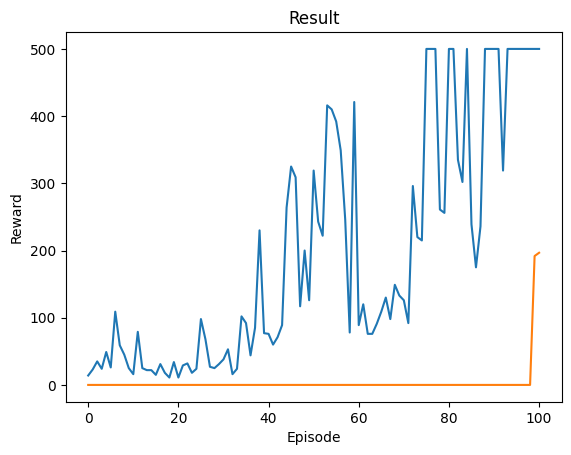

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
plot_durations(show_result=True)
plt.ioff()
plt.show()

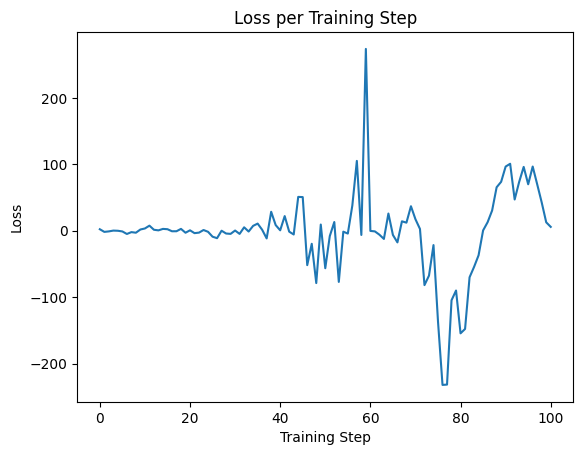

In [8]:
# Plot loss values
plt.figure(3)
plt.title('Loss per Training Step')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()